# Kmeans and TSNE Visualisation:
- This is just a visualisation tool for when we might want to search for different clusters within a label. Using Kmeans++ we can see the similarity and dissimarity between the data and using DBScan we can evaluate noise and outliers using the different scalers.
- Can be expanded further by integrating different algorithms through a pipeline.
https://scikit-learn.org/stable/auto_examples/neighbors/approximate_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-approximate-nearest-neighbors-py

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

In [27]:
class PlotClusters:
    """
    PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
    Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.

    Initialisation:
        - data (pd.DataFrame): The Dataset to analyse which should have the labels filtered out.
        - scaler_type (string): Either use 'standard' or 'minmax' scaler.
        - sample_size (int): Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
    """
    def __init__(self, data, scaler_type, sample_size):
        self.data = data.copy()

        # NOTE: Scaling seems to have a large impact on the number of clusters that are formed.
        if scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            self.scaler = StandardScaler()
        scaled_data = self.scaler.fit_transform(self.data)
        # Resample to a more manageable size. TSNE takes a very long time.
        self.data = resample(scaled_data, n_samples=sample_size, random_state=42)

    def plot_tsne(self, apply_pca=False, n_clusters=2, lr='auto', perplexity=30, cluster_type='kmeans', eps=0.5, min_samples=20):
        """
        plot_tsne: Use KMeans++ or DBSCAN clustering and visualisate it using 3 TSNE components in a 3D map. Augments the graph for more clear interpretations.
        
        Parameters:
        - apply_pca: Whether to apply PCA before t-SNE.
        - n_clusters: Number of clusters for KMeans++ clustering.
        - lr: Learning rate for t-SNE.
        - cluster_type: Clustering type ('kmeans' or 'dbscan').
        - eps: Epsilon for DBSCAN (a type of threshold for noise which specifies the size of the ring).
        - min_samples: Minimum amount of neighbouring points or rows to consider.

        """
        # NOTE: PCA is optional as TSNE can already project the data into 3D space. PCA can speed up the processing for TSNE
        # which is complex for high dimensional data.
        data = self.data
        if apply_pca:
            pca = PCA(n_components=3)
            data = pca.fit_transform(data)
            # Print Explainability of PCA components.
            print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")

        # Apply clustering (KMeans or DBSCAN).
        if cluster_type == 'kmeans':
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans_labels = kmeans.fit_predict(data)
            labels = kmeans_labels
        elif cluster_type == 'dbscan':
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(data)
            labels = dbscan_labels

        # Transform into a 3D space using TSNE.
        tsne = TSNE(n_components=3, random_state=42, learning_rate=lr, perplexity=perplexity)
        tsne_data = tsne.fit_transform(data)
        # Error occurs using numpy so needs to be converted.
        tsne_df = pd.DataFrame(tsne_data, columns=['v1', 'v2', 'v3'])
        tsne_df['Cluster'] = labels
        # Rotatation for the plots.
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')

            # Plots noise (-1) in red, others in a different color. Set alpha to low as it is usually the hard to see other points amongst it.
            if cluster_type == 'dbscan':
                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] == -1], 
                           tsne_df['v2'][tsne_df['Cluster'] == -1], 
                           tsne_df['v3'][tsne_df['Cluster'] == -1], 
                           color='#E45E4C', label='Noise', s=50, alpha=0.1, edgecolors='#A11E0C')

                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] != -1], 
                           tsne_df['v2'][tsne_df['Cluster'] != -1], 
                           tsne_df['v3'][tsne_df['Cluster'] != -1], 
                           c=tsne_df['Cluster'][tsne_df['Cluster'] != -1], 
                           cmap='tab20', s=50, alpha=0.8)

            # If KMeans, plot each cluster with a different color
            if cluster_type == 'kmeans':
                ax.scatter(tsne_df['v1'], tsne_df['v2'], tsne_df['v3'], 
                                     c=tsne_df['Cluster'], cmap='tab20', s=100, alpha=0.3, marker='o')

            ax.view_init(elev=elev, azim=azim)
        plt.suptitle(f"TSNE with {cluster_type.capitalize()}")
        plt.tight_layout()
        plt.show()

In [28]:
# Read one-hot encoded Cleaned Dataset.
data = pd.read_csv('Cleaned_full_data.csv')
data = data.reset_index(drop=True)
# First we set it to Normal label then remove labels.
# Unsupervised within label clustering uses no labels.
# We also remove the categorical columns that are encoded for the Neural Network.
data_normal = data[data['attack_cat'] =='Normal']
data_normal = data_normal.drop(columns=['attack_cat', 'label', 'srcip', 'sport', 'dsport', 'dstip', 'proto', 'state', 'service'])

C:\Users\adi_s\AppData\Local\Temp\ipykernel_15688\4141464554.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [29]:
# Now we try and filter for mostly continuous variables.
# Collect variables.
remove = []
for i in data_normal:
    if len(data_normal[i].unique()) < 10:
        remove.append(i)
# Drop the varibles collected.
data_normal = data_normal.drop(columns=remove)

# Standard Scaling

Here we evaluate what the data looks like for Normal labels using Standard Scaling. For Kmeans++ it seperates the data into 1 very large cluster which is identified as noise in DBScan and 3 medium sized clusters. There is also a smaller cluster and the last cluster seems to be distinct with a single point. The number of clusters is guided by DBScan algorithm which also generated 7. For DBScan a lot of noise is seen in the Normal labels and these points are considered anomalies in the data that a very disimilar to the general Normal data. The DBScan algorithm manages to find two large clusters and and 4 smaller clusters.

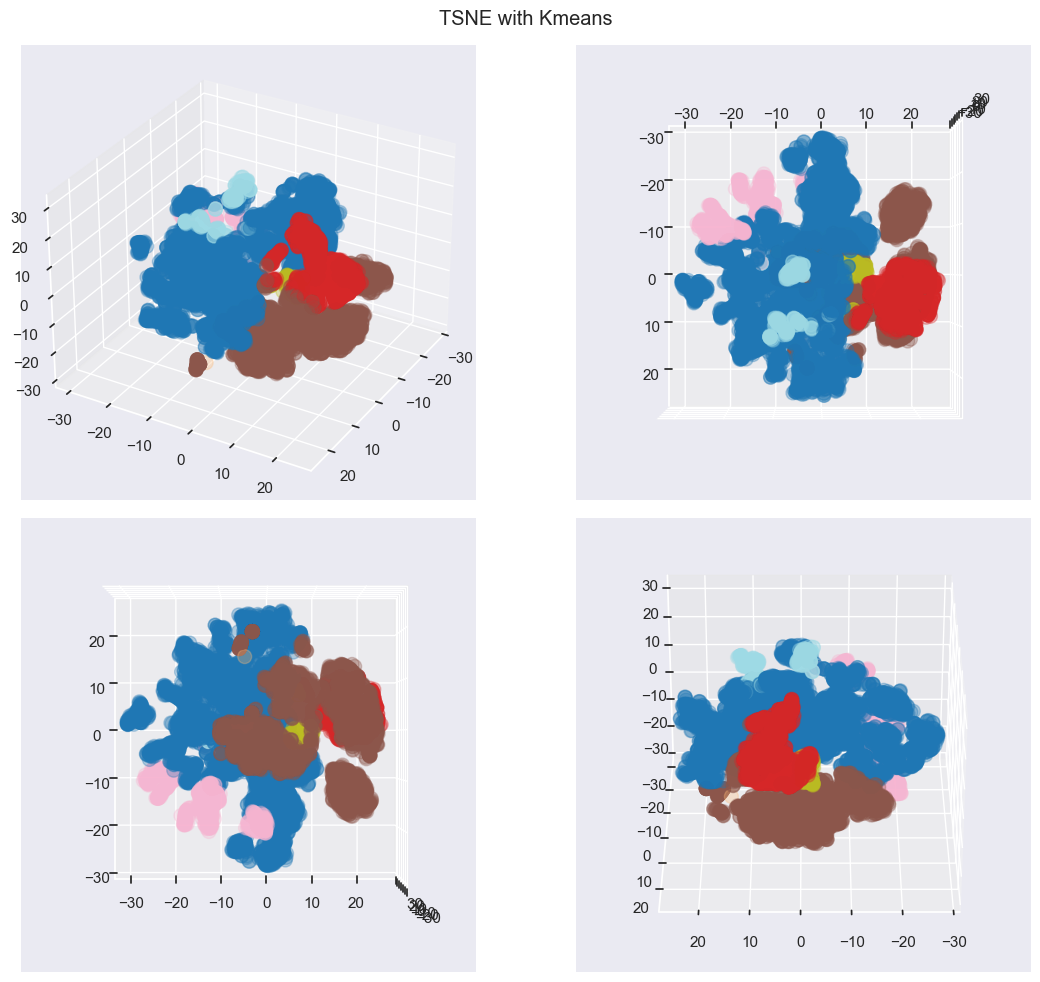

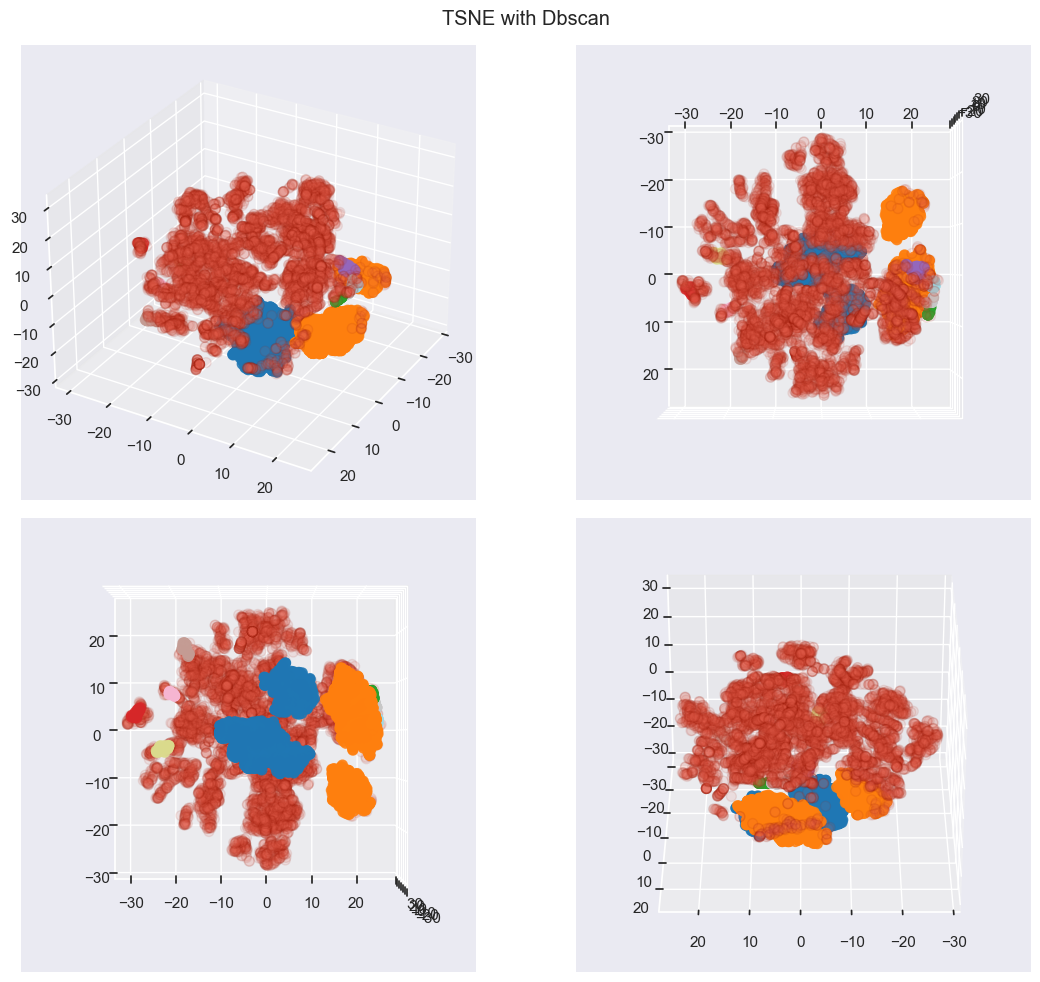

In [32]:
# Plot Clusters in 3D.
pc = PlotClusters(data_normal, scaler_type='standard', sample_size=10000)
pc.plot_tsne(apply_pca=False, n_clusters=7, lr='auto', perplexity=30, cluster_type='kmeans')
pc.plot_tsne(apply_pca=False, lr='auto', perplexity=30, cluster_type='dbscan', eps=0.5, min_samples=20)

# MinMax Scaling

Here we evaluate what the data looks like for Normal labels using MinMax Scaling. For Kmeans++ it seems to be able to better seperate the data. The largest cluster seems to be split apart into two and we have also effectively removed the single point 7th cluster. For DBScan the noise is effectively reduced and the algorithm generates only 5 clusters with 4 being similar in medium size and 1 smaller cluster.

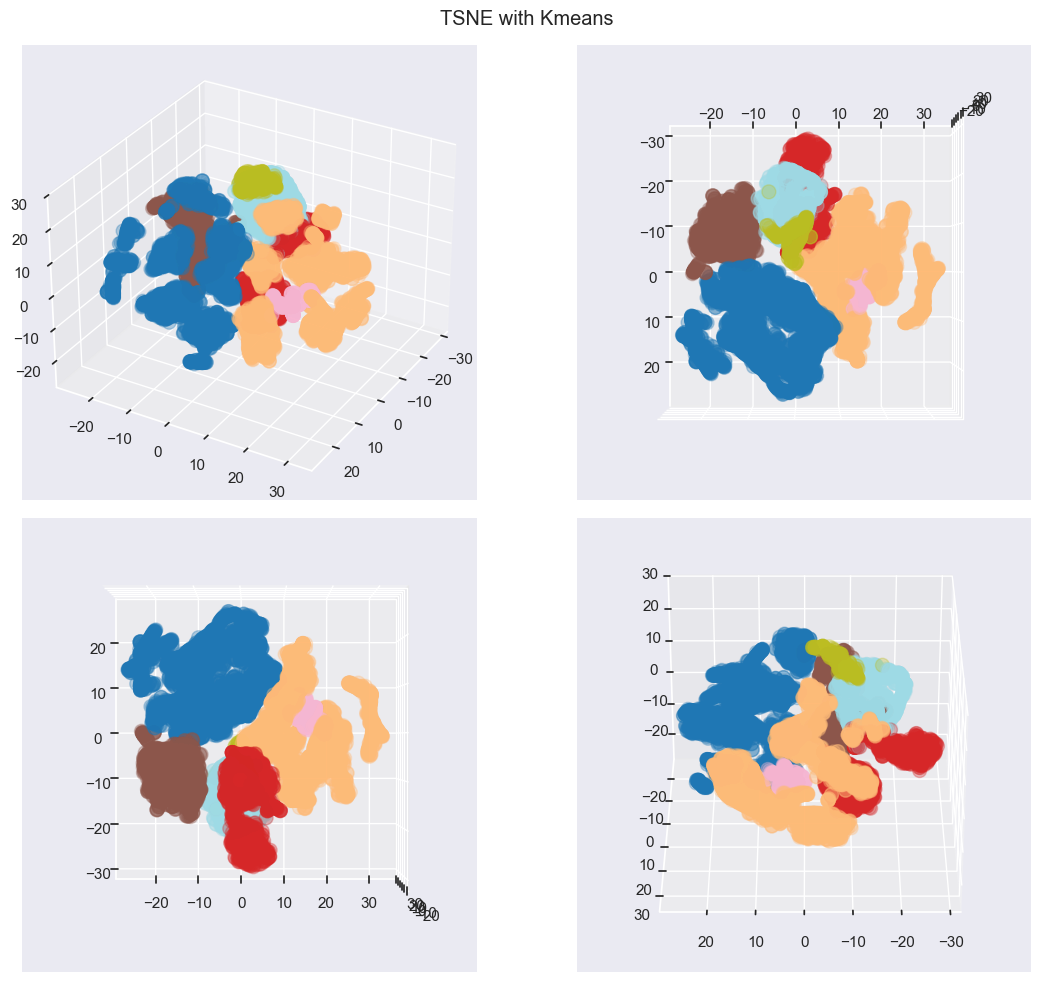

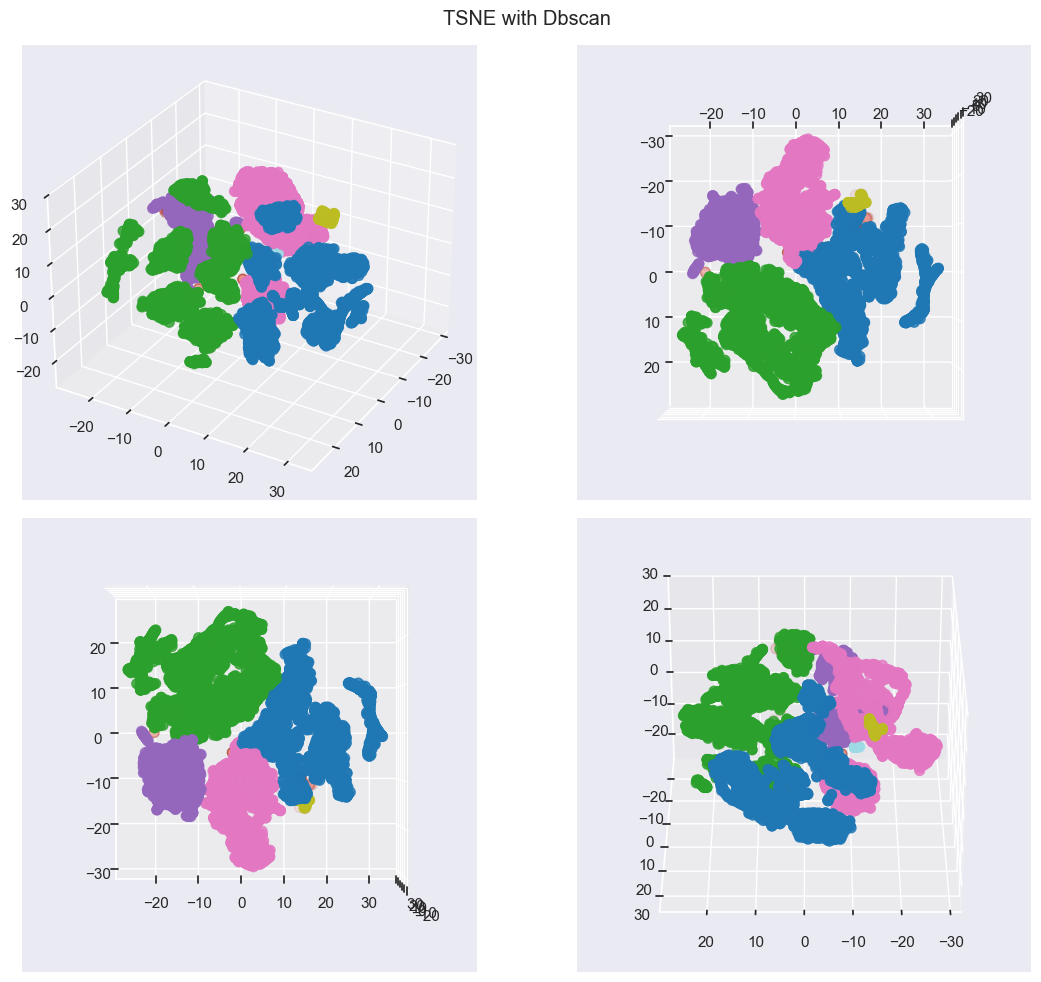

In [33]:
# Plot Clusters in 3D.
pc = PlotClusters(data_normal, scaler_type='minmax', sample_size=10000)
pc.plot_tsne(apply_pca=False, n_clusters=7, lr='auto', perplexity=30, cluster_type='kmeans')
pc.plot_tsne(apply_pca=False, lr='auto', perplexity=30, cluster_type='dbscan', eps=0.5, min_samples=20)